# EDA
---
**08.05.2019**

**NOTE:** The aim is to understand the data structure and to find potential information that is not visible at first glance. The basic selection of feathers and the feature engeniering will be carried out.

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import gc
import ast
import time
import math
from datetime import datetime
%matplotlib inline

## 2. Settings

In [2]:
# BITALINO

BITALINO_RAW_DATA_SOURCE_DIR = "./data/raw_data/bitalino"
BITALINO_RAW_DATA_SAMPLE_FILES = [
    '9744_opensignals_prawestanowisko_2019-04-09_15-03-06.txt',
    '9899_opensignals_prawestanowisko_2019-04-10_09-12-47.txt',
    '9926_opensignals_prawestanowisko_2019-04-16_09-22-08.txt',
    '9937_opensignals_prawestanowisko_2019-04-16_10-53-40.txt',
    '9952_opensignals_prawestanowisko_2019-04-11_12-15-54.txt'
]
BITALINO_COLUMNS_TO_USE = [5, 6]
BITALINO_COLUMN_NAMES = [
    "EKG", 
    "GSR"
]
BITALINO_SAMPLING_RATE_PER_SEC = 1000

# PROCEDURE

PROCEDURE_RAW_DATA_SOURCE_DIR = "./data/raw_data/procedura"
PROCEDURE_RAW_DATA_SAMPLE_FILES = [
    '9744_2019_Apr_09_1503.txt',
    '9899_2019_Apr_10_0913.txt',
    '9926_2019_Apr_16_0921.txt',
    '9937_2019_Apr_16_1053.txt',
    '9952_2019_Apr_11_1216.txt'
]

PROCEDURE_COLUMNS_TO_USE = [2, 3, 4, 5, 6, 7, 8, 9]
PROCEDURE_COLUMN_NAMES = [
    "CONDITION",
    "SPEC_CONDITION",
    "SOUND_NUM",
    "IMAGE_NUM",
    "WIDGET_TYPE",
    "WIDGET_RESPONSE",
    "RESPONSE_TIME",
    "TIMESTAMP"
]

## 3. Load Data

In [3]:
def load_data_bitalino(file_name, dir_path):
    file_path = os.path.join(dir_path, file_name)
    return pd.read_csv(
        file_path,sep="\t", 
        skiprows=3, 
        usecols=BITALINO_COLUMNS_TO_USE, 
        names=BITALINO_COLUMN_NAMES, 
        header=None
    )

In [4]:
def load_data_procedure(file_name, dir_path):
    file_path = os.path.join(dir_path, file_name)
    return pd.read_csv(
        file_path,sep="\t", 
        usecols=PROCEDURE_COLUMNS_TO_USE, 
        names=PROCEDURE_COLUMN_NAMES, 
        header=None
    )

In [5]:
IAPS_data = pd.read_csv("./data/IAPS.csv",sep=";")
IADS2_data = pd.read_csv("./data/IADS2.csv",sep=";")
NEOFFI_data = pd.read_csv("./data/NEO-FFI.txt",sep="\t")

BITALINO_data = { file_name[:4] : load_data_bitalino(file_name, BITALINO_RAW_DATA_SOURCE_DIR) for index, file_name in enumerate(BITALINO_RAW_DATA_SAMPLE_FILES) }
PROCEDURE_data = { file_name[:4] : load_data_procedure(file_name, PROCEDURE_RAW_DATA_SOURCE_DIR) for index, file_name in enumerate(PROCEDURE_RAW_DATA_SAMPLE_FILES) }

## 4. Data preprocessing

### 4.1. International Affective Picture System

In [6]:
IAPS_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 7 columns):
Description    1194 non-null object
IAPS           1194 non-null object
ValenceMean    1194 non-null object
ValenceSD      1194 non-null object
ArousalMean    1194 non-null object
ArousalSD      1194 non-null object
set            1194 non-null int64
dtypes: int64(1), object(6)
memory usage: 65.4+ KB


In [7]:
IAPS_data.head()

,Description,IAPS,ValenceMean,ValenceSD,ArousalMean,ArousalSD,set
0,Snake,1019,"3,95","1,96","5,77","1,83",12
1,Snake,1022,"4,26","2,04","6,02","1,97",12
2,Snake,1026,"4,09","1,91","5,61","2,23",16
3,Snake,1030,"4,3","2,35","5,46","2,43",1
4,Snake,1033,"3,87","1,94","6,13","2,15",18


**NOTE:** 
* Some ids are invalid and cannot be saved as int
* The numbers in ValenceMean, ValenceSD, ArousalMean and ArousalSD columns are written with commas. They have to be replaced with dots and loaded as float.

In [8]:
# Convert to int and if it fails, delete the row
IAPS_data['IAPS'] = pd.to_numeric(IAPS_data['IAPS'], errors='coerce')
IAPS_data = IAPS_data.dropna(subset=['IAPS'])
IAPS_data['IAPS'] = IAPS_data['IAPS'].astype('int')

IAPS_data['ValenceMean'] = IAPS_data['ValenceMean'].apply(lambda x: x.replace(',','.')).astype(float)
IAPS_data['ValenceSD'] = IAPS_data['ValenceSD'].apply(lambda x: x.replace(',','.')).astype(float)
IAPS_data['ArousalMean'] = IAPS_data['ArousalMean'].apply(lambda x: x.replace(',','.')).astype(float)
IAPS_data['ArousalSD'] = IAPS_data['ArousalSD'].apply(lambda x: x.replace(',','.')).astype(float)

In [9]:
IAPS_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1171 entries, 0 to 1193
Data columns (total 7 columns):
Description    1171 non-null object
IAPS           1171 non-null int64
ValenceMean    1171 non-null float64
ValenceSD      1171 non-null float64
ArousalMean    1171 non-null float64
ArousalSD      1171 non-null float64
set            1171 non-null int64
dtypes: float64(4), int64(2), object(1)
memory usage: 73.2+ KB


**NOTE:**
* 23 photo data were lost

### 4.2. International Affective Digitized Sounds (2nd Edition)

In [10]:
IADS2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 6 columns):
Sound          167 non-null object
Number         167 non-null int64
ValenceMean    167 non-null float64
ValenceSD      167 non-null float64
ArousalMean    167 non-null float64
ArousalSD      167 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.9+ KB


In [11]:
IADS2_data.head()

,Sound,Number,ValenceMean,ValenceSD,ArousalMean,ArousalSD
0,Cat,102,4.63,2.17,4.91,1.97
1,Panting,104,4.96,1.68,5.37,1.66
2,Puppy,105,2.88,2.14,6.40,2.13
3,Growl1,106,3.37,1.64,6.39,1.62
4,Dog,107,5.47,2.22,5.85,1.81


### 4.3. Personality questionnaire results

* **OTW** - Openness to experience - is a general appreciation for art, emotion, adventure, unusual ideas, imagination, curiosity, and variety of experience. People who are open to experience are intellectually curious, open to emotion, sensitive to beauty and willing to try new things. They tend to be, when compared to closed people, more creative and more aware of their feelings. They are also more likely to hold unconventional beliefs.

* **SUM** - Conscientiousness -  is a tendency to display self-discipline, act dutifully, and strive for achievement against measures or outside expectations. It is related to the way in which people control, regulate, and direct their impulses. High scores on conscientiousness indicate a preference for planned rather than spontaneous behavior. The average level of conscientiousness rises among young adults and then declines among older adults.

* **NEU** - Neuroticism - is the tendency to experience negative emotions, such as anger, anxiety, or depression. It is sometimes called emotional instability, or is reversed and referred to as emotional stability.

* **UGD** - Agreeableness - eflects individual differences in general concern for social harmony. Agreeable individuals value getting along with others. They are generally considerate, kind, generous, trusting and trustworthy, helpful, and willing to compromise their interests with others. Agreeable people also have an optimistic view of human nature.

* **EKST** - Extraversion - is characterized by breadth of activities (as opposed to depth), surgency from external activity/situations, and energy creation from external means. The trait is marked by pronounced engagement with the external world.

In [12]:
NEOFFI_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 8 columns):
ID      79 non-null int64
AGE     79 non-null int64
SEX     79 non-null object
OTW     79 non-null int64
SUM     79 non-null int64
NEU     79 non-null int64
UGD     79 non-null int64
EKST    79 non-null int64
dtypes: int64(7), object(1)
memory usage: 5.0+ KB


In [13]:
NEOFFI_data.head()

,ID,AGE,SEX,OTW,SUM,NEU,UGD,EKST
0,1107,21,F,4,6,3,4,10
1,1153,22,F,5,3,8,3,8
2,1233,21,F,6,8,2,10,7
3,1400,22,M,4,6,6,6,5
4,1402,27,F,9,7,7,4,7


### 4.4. Measurement data

### 4.4.1. Auxiliary function for retrieving timestamp from files 

In [14]:
def extract_start_time(file_name, dir_path):
    file_path = os.path.join(dir_path, file_name)
    metadata_str = None
    fp = open(file_path)
    
    # meta data are on the second line of the file
    for i, line in enumerate(fp):
        if i == 1:
            metadata_str = line
            fp.close()
            break
           
    # meta data starts with '# ' and ends with a new line sign
    metadata_str = metadata_str[2 : -1]
    # the meta data format is consistent with the Python dictionary
    metadata_dict = ast.literal_eval(metadata_str)
    
    # HACK: the acquired dictionary is nested but has only one key on the first level
    key_name = list(metadata_dict)[0]
    
    time_str = metadata_dict[key_name]['time']
    date_str = metadata_dict[key_name]['date']
    datetime_str = date_str + "," + time_str
    
    return time.mktime(datetime.strptime(datetime_str, "%Y-%m-%d,%H:%M:%S.%f").timetuple())

In [15]:
BITALINO_start_times = { file_name[:4] : extract_start_time(file_name, BITALINO_RAW_DATA_SOURCE_DIR) for index, file_name in enumerate(BITALINO_RAW_DATA_SAMPLE_FILES) }

### 4.4.2. Adding timestamp column

In [16]:
# Available keys
print(BITALINO_data.keys())
print(BITALINO_start_times.keys())

dict_keys(['9744', '9899', '9926', '9937', '9952'])
dict_keys(['9744', '9899', '9926', '9937', '9952'])


In [17]:
for key, data in BITALINO_data.items():
    start_timestamp = BITALINO_start_times[key]
    data["TIMESTAMP"] = start_timestamp + data.index

In [18]:
BITALINO_data['9744'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221000 entries, 0 to 4220999
Data columns (total 3 columns):
EKG          int64
GSR          int64
TIMESTAMP    float64
dtypes: float64(1), int64(2)
memory usage: 96.6 MB


In [19]:
BITALINO_data['9744'].head()

,EKG,GSR,TIMESTAMP
0,506,317,1.554815e+09
1,506,317,1.554815e+09
2,504,317,1.554815e+09
3,504,317,1.554815e+09
4,504,317,1.554815e+09


### 4.4.3. EKG data preview

In [20]:
PREVIEW_LENGHT_SEC = 10

In [21]:
preview_dataset = BITALINO_data['9744'].head(BITALINO_SAMPLING_RATE_PER_SEC * PREVIEW_LENGHT_SEC)["EKG"]

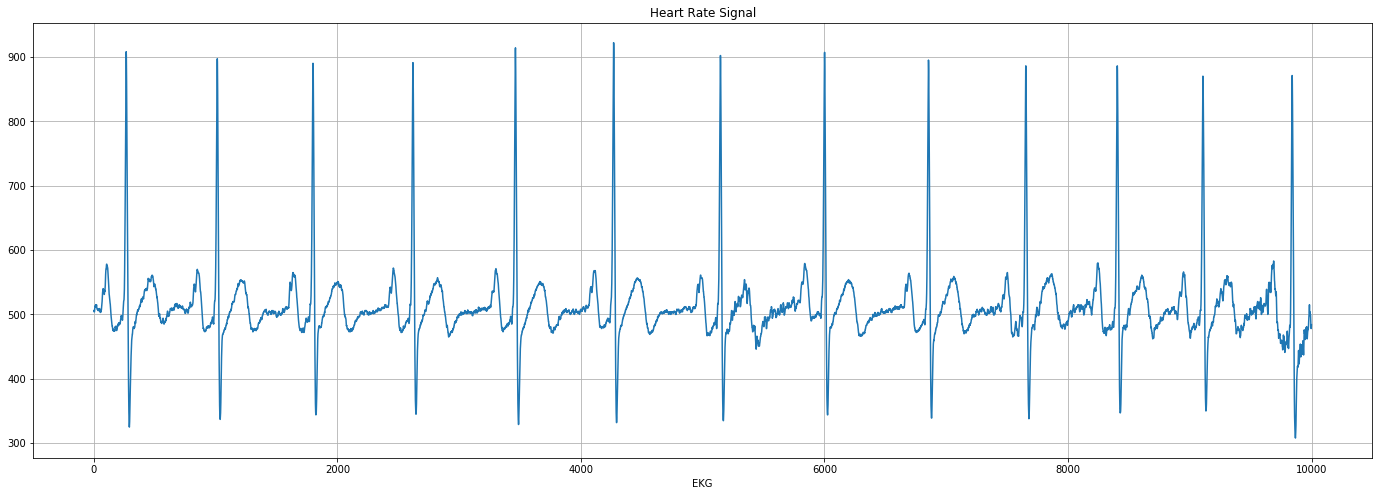

In [22]:
plt.figure(figsize=(24, 8))
plt.title("Heart Rate Signal")
plt.xlabel('time (ms)')
plt.xlabel('EKG')
plt.plot(preview_dataset)
plt.grid()
plt.show() 

/home/skalskip/Documents/REPOS/ImaBoss/.env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


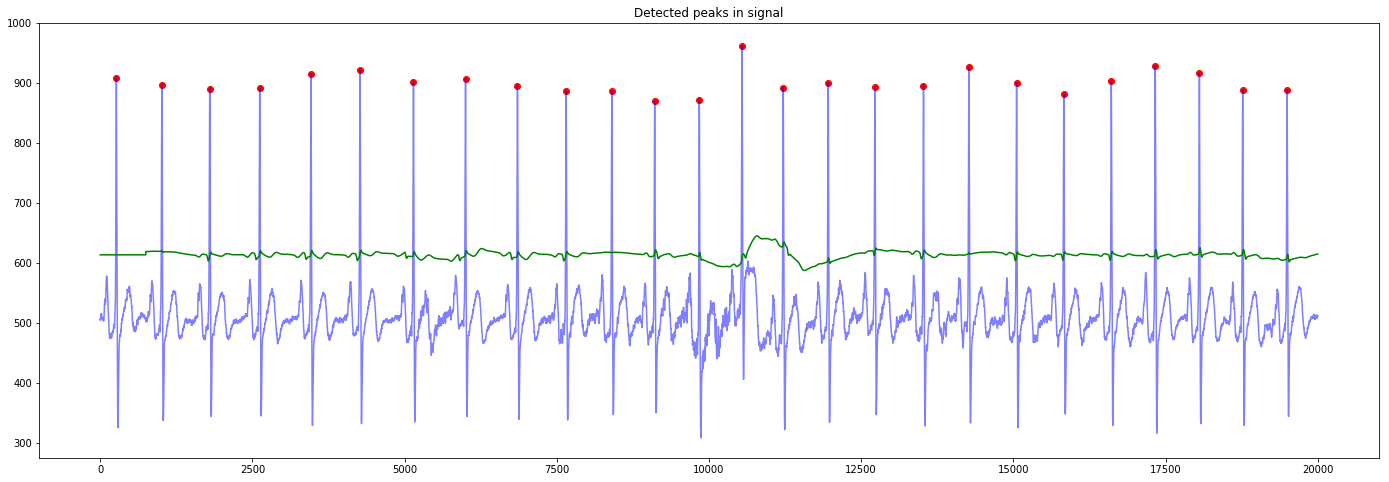

In [23]:
dataset = BITALINO_data['9744'].head(20000)
#Calculate moving average with 0.75s in both directions, then append do dataset
hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
fs = 1000 #The example dataset was recorded at 100Hz
mov_avg = dataset['EKG'].rolling(int(hrw*fs)).mean() #Calculate moving average
#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset['EKG']))
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['hart_rollingmean'] = mov_avg #Append the moving average to the dataframe
#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset['EKG']:
    rollingmean = dataset['hart_rollingmean'][listpos] #Get local mean
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1
    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1
ybeat = [dataset['EKG'][x] for x in peaklist] #Get the y-value of all peaks for plotting purposes
plt.figure(figsize=(24, 8))
plt.title("Detected peaks in signal")
plt.plot(dataset['EKG'], alpha=0.5, color='blue') #Plot semi-transparent HR
plt.plot(mov_avg, color ='green') #Plot moving average
plt.scatter(peaklist, ybeat, color='red') #Plot detected peaks
plt.show()

In [24]:
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1
bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
print(bpm)

77.99906401123187


In [25]:
preview_dataset = BITALINO_data['9744'].head(BITALINO_SAMPLING_RATE_PER_SEC * PREVIEW_LENGHT_SEC)["GSR"]

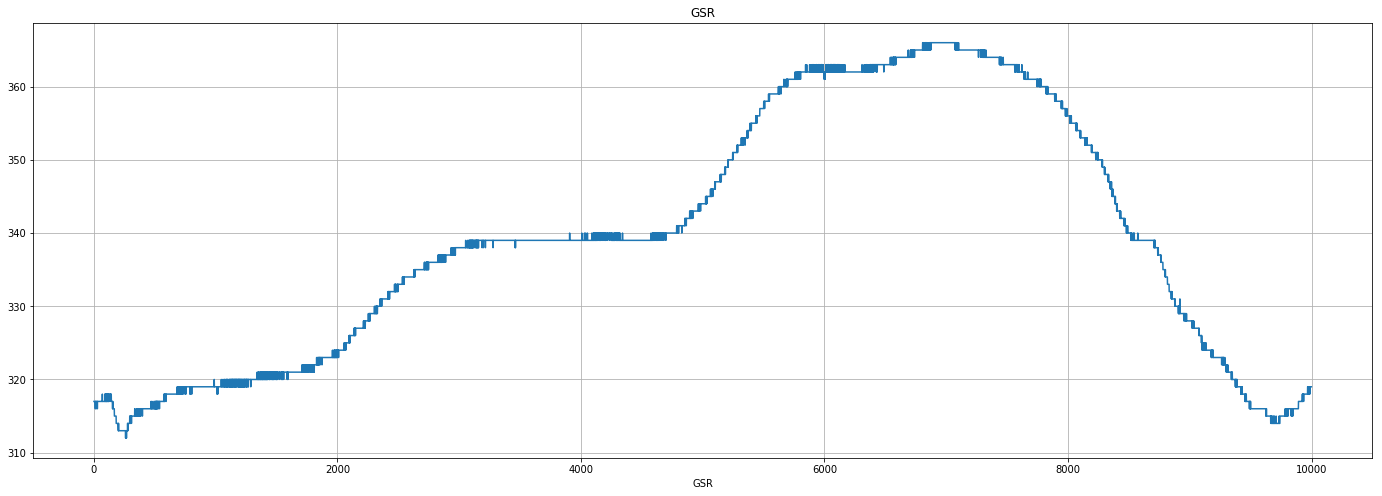

In [26]:
plt.figure(figsize=(24, 8))
plt.title("GSR")
plt.xlabel('time (ms)')
plt.xlabel('GSR')
plt.plot(preview_dataset)
plt.grid()
plt.show() 

### 4.5. Procedure data

In [27]:
# Available keys
print(PROCEDURE_data.keys())

dict_keys(['9744', '9899', '9926', '9937', '9952'])


In [28]:
PROCEDURE_data['9744'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
CONDITION          120 non-null object
SPEC_CONDITION     120 non-null object
SOUND_NUM          120 non-null int64
IMAGE_NUM          120 non-null int64
WIDGET_TYPE        120 non-null object
WIDGET_RESPONSE    120 non-null object
RESPONSE_TIME      120 non-null object
TIMESTAMP          120 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 7.6+ KB


In [29]:
PROCEDURE_data['9744'].head()

,CONDITION,SPEC_CONDITION,SOUND_NUM,IMAGE_NUM,WIDGET_TYPE,WIDGET_RESPONSE,RESPONSE_TIME,TIMESTAMP
0,inc,p+s-,502,8034,emoscale1,3,None,1.554815e+09
1,con,p0s0,120,1945,emoscale1,2.0,0.33376046287230565,1.554815e+09
2,con,p-s-,624,9902,emoscale1,2.0,0.3170798987375747,1.554815e+09
3,inc,p+s-,624,4652,emoscale1,4.0,0.6675173238108982,1.554815e+09
4,inc,p+s-,312,8370,emoscale1,3,None,1.554815e+09


### 4.5.1. Feature engineering

In [30]:
def spec_condition_helper(x):
    if x=='-':
        return(0)
    elif x=='0':
        return(1)
    elif x=='+':
        return(2)

In [32]:
for key, data in PROCEDURE_data.items():
    data["CONSISTENT"] = data['CONDITION'].apply(lambda x: x=="con").astype(int)
    data["IMAGE_ATTRIBUTE"] = data['SPEC_CONDITION'].apply(lambda x: spec_condition_helper(x[1])).astype(int)
    data["SOUND_ATTRIBUTE"] = data['SPEC_CONDITION'].apply(lambda x: spec_condition_helper(x[3])).astype(int)
    data["WIDGET_TYPE"] = data["WIDGET_TYPE"].apply(lambda x: x=="emoscale1").astype(int)
    data.drop(["Description", "set"], axis=1)

In [33]:
PROCEDURE_data['9744'].head()

,CONDITION,SPEC_CONDITION,SOUND_NUM,IMAGE_NUM,WIDGET_TYPE,WIDGET_RESPONSE,RESPONSE_TIME,TIMESTAMP,CONSISTENT,IMAGE_ATTRIBUTE,SOUND_ATTRIBUTE
0,inc,p+s-,502,8034,1,3,None,1.554815e+09,0,2,0
1,con,p0s0,120,1945,1,2.0,0.33376046287230565,1.554815e+09,1,1,1
2,con,p-s-,624,9902,1,2.0,0.3170798987375747,1.554815e+09,1,0,0
3,inc,p+s-,624,4652,1,4.0,0.6675173238108982,1.554815e+09,0,2,0
4,inc,p+s-,312,8370,1,3,None,1.554815e+09,0,2,0
